# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5241856479297082 -2.4869053002172326
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [182]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [183]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [184]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [186]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training) # nextQs/targetQs
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True) # Qs
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    return actions_logits, gQs, gloss, dloss

In [187]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [188]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [189]:
def sample(buffer, batch_size):
    idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
    return np.array([buffer[ii] for ii in idx])

In [190]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [191]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [192]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [193]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [194]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1 # [-1, +1] or [0, 1]
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500 # [0, 1]
        total_reward = 0
        for idx in range(num_step):
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [195]:
def minibatch(batch):
    #batch = memory.buffer
    rates = np.array([each[-1] for each in batch])
    ##############################
    states = np.array([each[0] for each in batch])[rates > 0]
    actions = np.array([each[1] for each in batch])[rates > 0]
    next_states = np.array([each[2] for each in batch])[rates > 0]
    rewards = np.array([each[3] for each in batch])[rates > 0]
    dones = np.array([each[4] for each in batch])[rates > 0]
    rates = np.array([each[5] for each in batch])[rates > 0]
    ##########################################
    maxstates = states[rates > (max(rates)*0.5)]
    maxactions = actions[rates > (max(rates)*0.5)]
    maxnext_states = next_states[rates > (max(rates)*0.5)]
    maxrewards = rewards[rates > (max(rates)*0.5)]
    maxdones = dones[rates > (max(rates)*0.5)]
    maxrates = rates[rates > (max(rates)*0.5)]
    ##################################################
    minstates = states[rates < (max(rates)*0.5)]
    minactions = actions[rates < (max(rates)*0.5)]
    minnext_states = next_states[rates < (max(rates)*0.5)]
    minrewards = rewards[rates < (max(rates)*0.5)]
    mindones = dones[rates < (max(rates)*0.5)]
    minrates = rates[rates < (max(rates)*0.5)]
    #################################################
    maxstates = sample(batch_size=batch_size, buffer=maxstates)
    minstates = sample(batch_size=batch_size, buffer=minstates)
    maxactions = sample(batch_size=batch_size, buffer=maxactions)
    minactions = sample(batch_size=batch_size, buffer=minactions)
    maxnext_states = sample(batch_size=batch_size, buffer=maxnext_states)
    minnext_states = sample(batch_size=batch_size, buffer=minnext_states)
    maxrewards = sample(batch_size=batch_size, buffer=maxrewards)
    minrewards = sample(batch_size=batch_size, buffer=minrewards)
    maxdones = sample(batch_size=batch_size, buffer=maxdones)
    mindones = sample(batch_size=batch_size, buffer=mindones)
    maxrates = sample(batch_size=batch_size, buffer=maxrates)
    minrates = sample(batch_size=batch_size, buffer=minrates)
    #################################################################
    states = np.concatenate([maxstates, minstates], axis=0)
    actions = np.concatenate([maxactions, minactions], axis=0)
    next_states = np.concatenate([maxnext_states, minnext_states], axis=0)
    rewards = np.concatenate([maxrewards, minrewards], axis=0)
    dones = np.concatenate([maxdones, mindones], axis=0)
    rates = np.concatenate([maxrates, minrates], axis=0)
    return states, actions, next_states, rewards, dones, rates

In [196]:
batch = memory.buffer
states, actions, next_states, rewards, dones, rates = minibatch(batch=batch)

In [197]:
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape, \
states.dtype, actions.dtype, next_states.dtype, rewards.dtype, dones.dtype, rates.dtype

((200, 4),
 (200,),
 (200, 4),
 (200,),
 (200,),
 (200,),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], [] # goal
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch = [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1 # [-1, +1] or [0, 1]
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # memory incremented
            total_reward += reward
            state = next_state
            
            # Rating
            if done is True:
                rate = total_reward/500 # [0, 1]
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training
            batch = memory.buffer
            states, actions, next_states, rewards, dones, rates = minibatch(batch=batch)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states,
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt],feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates,
                                                                         model.training: True})
            gloss, _ = sess.run([model.g_loss, model.g_opt],feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs, 
                                                                         model.rates: rates,
                                                                         model.training: True})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:30.0000 R:30.0000 rate:0.0600 gloss:1.4582 dloss:1.3881 exploreP:0.9970
Episode:1 meanR:22.5000 R:15.0000 rate:0.0300 gloss:1.4380 dloss:1.3713 exploreP:0.9956
Episode:2 meanR:26.6667 R:35.0000 rate:0.0700 gloss:1.4199 dloss:1.3549 exploreP:0.9921
Episode:3 meanR:28.5000 R:34.0000 rate:0.0680 gloss:1.3990 dloss:1.3345 exploreP:0.9888
Episode:4 meanR:27.4000 R:23.0000 rate:0.0460 gloss:1.3790 dloss:1.3165 exploreP:0.9865
Episode:5 meanR:25.6667 R:17.0000 rate:0.0340 gloss:1.3748 dloss:1.3153 exploreP:0.9849
Episode:6 meanR:23.7143 R:12.0000 rate:0.0240 gloss:1.3627 dloss:1.3060 exploreP:0.9837
Episode:7 meanR:23.3750 R:21.0000 rate:0.0420 gloss:1.3519 dloss:1.2976 exploreP:0.9817
Episode:8 meanR:22.0000 R:11.0000 rate:0.0220 gloss:1.3482 dloss:1.2957 exploreP:0.9806
Episode:9 meanR:21.1000 R:13.0000 rate:0.0260 gloss:1.3312 dloss:1.2834 exploreP:0.9793
Episode:10 meanR:20.8182 R:18.0000 rate:0.0360 gloss:1.3443 dloss:1.2880 exploreP:0.9776
Episode:11 meanR:21.0000 R:23.0

Episode:93 meanR:25.1170 R:62.0000 rate:0.1240 gloss:1.2278 dloss:1.2129 exploreP:0.7918
Episode:94 meanR:25.1263 R:26.0000 rate:0.0520 gloss:1.2296 dloss:1.2137 exploreP:0.7898
Episode:95 meanR:25.0729 R:20.0000 rate:0.0400 gloss:1.2273 dloss:1.2109 exploreP:0.7882
Episode:96 meanR:25.3608 R:53.0000 rate:0.1060 gloss:1.2243 dloss:1.2101 exploreP:0.7841
Episode:97 meanR:26.1122 R:99.0000 rate:0.1980 gloss:1.2219 dloss:1.2077 exploreP:0.7765
Episode:98 meanR:26.0101 R:16.0000 rate:0.0320 gloss:1.2206 dloss:1.2075 exploreP:0.7753
Episode:99 meanR:25.9400 R:19.0000 rate:0.0380 gloss:1.2243 dloss:1.2094 exploreP:0.7738
Episode:100 meanR:25.8600 R:22.0000 rate:0.0440 gloss:1.2196 dloss:1.2062 exploreP:0.7721
Episode:101 meanR:26.1200 R:41.0000 rate:0.0820 gloss:1.2192 dloss:1.2074 exploreP:0.7690
Episode:102 meanR:25.9600 R:19.0000 rate:0.0380 gloss:1.2197 dloss:1.2065 exploreP:0.7676
Episode:103 meanR:25.7600 R:14.0000 rate:0.0280 gloss:1.2183 dloss:1.2071 exploreP:0.7665
Episode:104 meanR

Episode:185 meanR:30.1700 R:24.0000 rate:0.0480 gloss:1.1422 dloss:1.1390 exploreP:0.6051
Episode:186 meanR:30.2400 R:21.0000 rate:0.0420 gloss:1.1410 dloss:1.1379 exploreP:0.6039
Episode:187 meanR:30.4300 R:45.0000 rate:0.0900 gloss:1.1392 dloss:1.1361 exploreP:0.6012
Episode:188 meanR:30.4600 R:38.0000 rate:0.0760 gloss:1.1419 dloss:1.1390 exploreP:0.5990
Episode:189 meanR:30.6500 R:34.0000 rate:0.0680 gloss:1.1379 dloss:1.1343 exploreP:0.5970
Episode:190 meanR:30.9900 R:51.0000 rate:0.1020 gloss:1.1394 dloss:1.1363 exploreP:0.5940
Episode:191 meanR:30.4300 R:27.0000 rate:0.0540 gloss:1.1385 dloss:1.1358 exploreP:0.5924
Episode:192 meanR:30.4300 R:37.0000 rate:0.0740 gloss:1.1402 dloss:1.1376 exploreP:0.5903
Episode:193 meanR:29.9900 R:18.0000 rate:0.0360 gloss:1.1384 dloss:1.1347 exploreP:0.5892
Episode:194 meanR:29.9800 R:25.0000 rate:0.0500 gloss:1.1383 dloss:1.1355 exploreP:0.5878
Episode:195 meanR:30.1900 R:41.0000 rate:0.0820 gloss:1.1389 dloss:1.1361 exploreP:0.5854
Episode:19

Episode:277 meanR:33.3800 R:31.0000 rate:0.0620 gloss:1.1232 dloss:1.1208 exploreP:0.4460
Episode:278 meanR:33.4600 R:45.0000 rate:0.0900 gloss:1.1260 dloss:1.1239 exploreP:0.4441
Episode:279 meanR:33.5300 R:38.0000 rate:0.0760 gloss:1.1240 dloss:1.1220 exploreP:0.4424
Episode:280 meanR:33.6100 R:43.0000 rate:0.0860 gloss:1.1307 dloss:1.1288 exploreP:0.4406
Episode:281 meanR:33.8000 R:45.0000 rate:0.0900 gloss:1.1276 dloss:1.1254 exploreP:0.4386
Episode:282 meanR:34.3300 R:68.0000 rate:0.1360 gloss:1.1255 dloss:1.1234 exploreP:0.4357
Episode:283 meanR:34.2600 R:18.0000 rate:0.0360 gloss:1.1222 dloss:1.1196 exploreP:0.4350
Episode:284 meanR:34.2300 R:31.0000 rate:0.0620 gloss:1.1250 dloss:1.1229 exploreP:0.4336
Episode:285 meanR:34.3600 R:37.0000 rate:0.0740 gloss:1.1234 dloss:1.1214 exploreP:0.4321
Episode:286 meanR:34.3800 R:23.0000 rate:0.0460 gloss:1.1253 dloss:1.1231 exploreP:0.4311
Episode:287 meanR:34.1400 R:21.0000 rate:0.0420 gloss:1.1269 dloss:1.1250 exploreP:0.4302
Episode:28

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

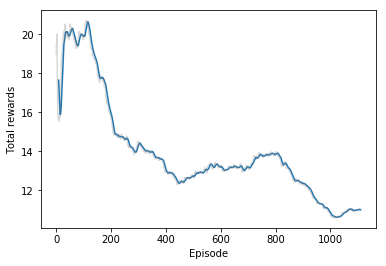

In [155]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

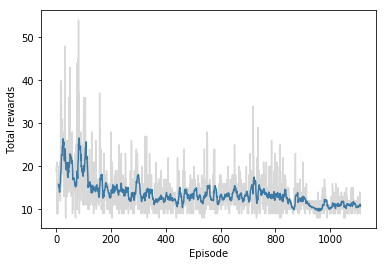

In [158]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

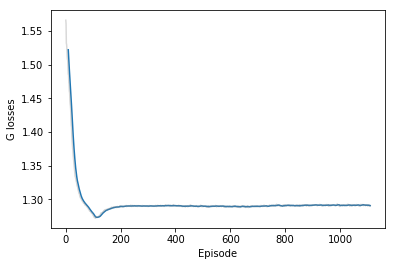

In [160]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

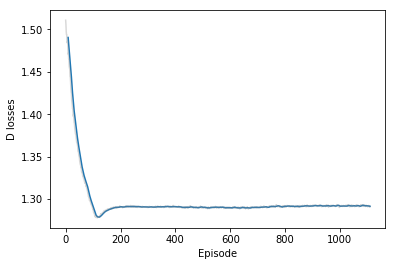

In [161]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.